# Agentic system for image generation - Planning and Reflection


* 02_stepwise-SD - 플레닝, 리플렉션으로 이미지 생성하기 - 언제 이런게 좋은지 케이스 몇개 찾기
* 01_agentic_system_for_image_generator_text_editing_history - 이전 생성 이미지 컨디션으로 주면서 텍스트로 에디팅 하는 기능 만들기
* 01_agentic_system_for_image_generator_in_out_painting_agent - 컨디션 이미지(원본, 마스킹, 이미지를 기반으로 텍스트 에디팅 하기)
    - 마스킹 이미지 생성 앱에서 하는 것 추가

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 4096,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

- "SD-3-5-Large": "stability.sd3-5-large-v1:0",
- "SD-Ultra": "stability.stable-image-ultra-v1:1",
- "SD-3-Large": "stability.sd3-large-v1:0"

In [7]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="SD-Ultra"),
    bedrock_client=boto3_bedrock
)

## 3. Analysis

In [8]:
import io
import time
import json
import random
import pprint
import base64
import traceback
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, Optional, List
from src.genai_anaysis import llm_call
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

from utils.common_utils import retry
from botocore.exceptions import ClientError, ConnectionError, ConnectTimeoutError, ReadTimeoutError

In [9]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

## Conventional Text2Image

In [17]:
import random

def _body_generator(pos_prompt, neg_prompt="", condition_image=None, condition_strength=None, seed=1):
    
    if condition_image == None:
        body_dict = {
            "prompt": pos_prompt,
            "negative_prompt": neg_prompt,
            "mode": "text-to-image",
            "aspect_ratio": "1:1",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
            "output_format": "png",
            "seed": seed
        }
    else:
        body_dict = {
            "prompt": pos_prompt,
            "negative_prompt": neg_prompt,
            "mode": "image-to-image",
            "strength": condition_strength,
            "image": condition_image,
            "output_format": "png",
            "seed": seed
        }

    return json.dumps(body_dict)

def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"
        
def show_save_image(base64_string):
    try:

        # base64 문자열을 디코딩하여 바이너리 데이터로 변환
        image_data = base64.b64decode(base64_string)

        # 바이너리 데이터를 이미지로 변환
        image = Image.open(io.BytesIO(image_data))

        fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Generated Image')

        plt.tight_layout()  # 레이아웃 조정
        plt.show()

        # save images
        img_path = './generated_imgs/GENERATED_IMAGE.png'
        image.save(img_path, "PNG")

        return img_path

    except Exception as e:
        print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

stability.sd3-5-large-v1:0


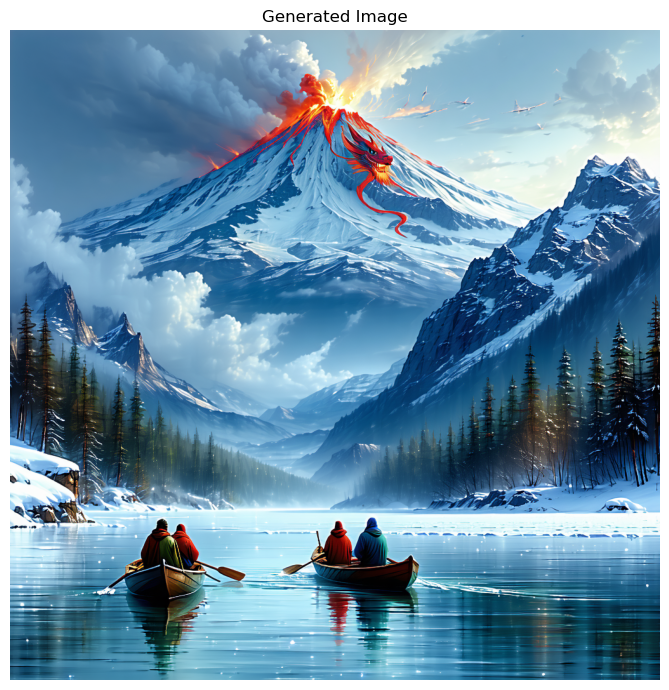

In [19]:
image_generation_model.model_id = "stability.sd3-5-large-v1:0"
#image_generation_model.model_id = "stability.stable-image-ultra-v1:1"

body = _body_generator(
    pos_prompt=
        '''
        An icy landscape.
        A vast expanse of snow-covered mountain peaks stretches endlessly.
        Beneath them is a dense forest and a colossal frozen lake.
        Three people are boating in three boats in the lake.
        Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar.
        Above the mountain, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow.
        Oil painting
        ''',
    seed=random.randint(0, 100000)
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)


response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
image_generation_model.model_id = "stability.sd3-5-large-v1:0"

body = _body_generator(
    pos_prompt=
        '''
        The word 'AWS AIML Specialist' in blue background and white letters is written on a black wall, with a redbike in front of it.
        Oil painting style
        ''',
    seed=random.randint(0, 100000)
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)


response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
image_generation_model.model_id = "stability.sd3-5-large-v1:0"

body = _body_generator(
    pos_prompt=
        '''
        One candle in the middle,\
        one sheep and one dogs nearby,\
        three bees in the air,\
        creates a warm atmosphere.
        ''',
    seed=random.randint(0, 100000)
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)


response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
image_generation_model.model_id = "stability.sd3-5-large-v1:0"
#image_generation_model.model_id = "stability.stable-image-ultra-v1:1"

body = _body_generator(
    pos_prompt=
        '''
        An icy landscape.
        A vast expanse of snow-covered mountain peaks stretches endlessly.
        Beneath them is a dense forest and a colossal frozen lake.
        Three people are boating in three boats in the lake.
        Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar.
        Above the mountain, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow.
        Oil painting
        ''',
    seed=random.randint(0, 100000)
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)


response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

## Agentic system for Text2Image

### 3.1 Agent state 

In [11]:
class GraphState(TypedDict):
    ask: str
    
    total_steps: int
    steps: List[str]

    seed: int
    current_step: int
    condition_image: str

    suggestions: str
    prompt_repo: dict
    retry_count: int
    prev_node: str
    should_regeneration: str

    reset: bool

In [12]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))

            fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_title('Generated Image')

            plt.tight_layout()  # 레이아웃 조정
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            time.sleep(3)
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, pos_prompt, neg_prompt="", condition_image=None, control_strength=None, seed=1):
        
        
        
        print ("_body_generator, control_strength", control_strength)
    
        if condition_image == None:
            self.image_generation_model.model_id = "stability.stable-image-ultra-v1:1"
            print (f'Image generator: SD-Ultra')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "text-to-image",
                "aspect_ratio": "3:2",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
                "output_format": "png",
                "seed": seed
            }
        else:
            self.image_generation_model.model_id = "stability.sd3-5-large-v1:0"
            print (f'Image generator: SD-3-5-Large')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "image-to-image",
                "strength": control_strength, # nova랑 반대
                "image": condition_image,
                "output_format": "png",
                "seed": seed
            }

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def StepwiseTaskDecomposer(state):

            self.timer.start()
            self.timer.reset()
            
            print("---StepwiseTaskDecomposer---")
            ask = state["ask"]
            current_step = state.get("current_step", 1)
            messages = []
        
            system_prompts = dedent(
                
                '''
                You are an agent that plans steps for stepwise image generation based on user requests.

                Core Responsibilities:
                
                1. Break down user requests into manageable steps that:
                   - Prioritize single step generation when feasible
                   - Only split into multiple steps (2-3) when complexity demands it
                     (e.g. layered scenes, multiple focal points, complex interactions)
                   - Follow control mode restrictions (NONE for step 1, SEGMENTATION after)
                   - Progress from core elements to details
                   - Use appropriate control strength for smooth transitions
                   - Track and maintain key subject properties:
                     * Exact counts (e.g., "3 boats with passengers" not just "3 boats")
                     * Spatial orientations (e.g., "facing left")
                     * Specific attributes (e.g., "red cars" not just "cars")
                     * Relationships between subjects (e.g., "person sitting in each boat")

                2. For each step, provide:
                   - Start with new elements in prompt generation
                   - Step description
                   - Image generation prompt that have to maintain key subjects(people, car, etc) and elements from previous steps while clearly specifying new additions
                   - Add detailed improvements (style, lighting etc)
                   - Control mode (NONE/SEGMENTATION)
                   - Control strength (0.0-1.0, N/A for step 1)

                Step Planning Guidelines:
                First Step (Composition & Subject):
                - Uses NONE control mode
                - No control strength applicable
                - Must establish:
                  * Overall scene composition
                  * Main subjects and objects
                  * Spatial relationships and viewpoint
                  * Foreground/background structure
                  * Space allocation for future elements

                Subsequent Steps:
                - Uses SEGMENTATION control mode
                - Each prompt should explicitly reference maintaining previous subjects and elements
                - Control strength: 0.8-0.95 recommended
                - Consider new elements' impact when selecting control strength
                
                Scene Composition Rules:
                1. Foreground/Background
                   - Specify clear spatial relationships
                   - Maintain distinct layering
                   - Use explicit positioning terms

                2. Spatial Relationships
                   - Use clear position indicators (left, right, near, far)
                   - Consider depth and perspective
                   - Be explicit about distances and relationships

                Prompt Writing Guidelines:
                - Use image captioning style
                - Start with new elements
                - Maintain consistent style across steps
                - Use clear, simple language
                - Keep under 10,000 characters
                - Include:
                  * Spatial relationships
                  * Depth indicators
                  * Viewing angles when relevant
                  * Style keywords at end

                Output Format:
                DO NOT include any text outside the JSON format in the response
                You must provide your response in the following JSON format:
                {
                    "total_steps": <number_of_steps>,
                    "steps": [
                        {
                            "step_number": <number>,
                            "description": <string>,
                            "control_mode": <"NONE"/"SEGMENTATION">,
                            "control_strength": <null/float>,
                            "prompt": {
                                "positive": <string>,
                                "negative": <string>
                            }
                        }
                    ]
                }

                Key Requirements:
                - Each step builds on previous
                - Maintain style consistency across steps through:
                  * Matching artistic style keywords
                  * Consistent quality enhancers
                  * Uniform lighting/atmosphere descriptions
                  * Consistent camera/perspective terms
                
                '''
            )

            if current_step == 1:
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                user_prompts = dedent(
                    '''
                    Here is user's ask: <ask>{ask}</ask>
                    '''
                )
                context = {
                    "ask": ask,
                }
                user_prompts = user_prompts.format(**context)
                           
                message = self._get_message_from_string(role="user", string=user_prompts)
                self.messages.append(message)
                messages.append(message)
                
                resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                self.messages.append(ai_message)
                            
                results = json.loads(resp['text'])
                total_steps, steps = results["total_steps"], results["steps"]
                should_next_step = "next_step"
            
                return self.state(
                    total_steps=total_steps,
                    steps=steps,
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            else:
                generation_steps = state["steps"]
                if current_step <= len(generation_steps):
                    print ("---GO TO IMAGE GENERATION---")
                    print ("current_step: ", current_step)
                    should_next_step = "next_step"
                else:
                    should_next_step = "completed"
                    
                return self.state(
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            
            
        def ShouldStepwiseImageGeneration(state):

            print("---ShouldStepwiseImageGeneration---")
            return state["should_next_step"]
        
        @retry(total_try_cnt=5, sleep_in_sec=60, retryable_exceptions=(ClientError,))
        def ImageGeneration(state):
            
            print("---ImageGeneration---")
            generation_steps, current_step = state["steps"], state.get("current_step", 1)
            condition_image = state.get("condition_image", None)
            seed = state.get("seed", 1)
            prev_node = state.get("prev_node", None)
            
            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            control_mode = generation_steps[current_step-1]["control_mode"].upper()
            control_strength = generation_steps[current_step-1]["control_strength"]
            if prev_node == "PromptReformulation": seed = random.randint(0, 100000)

            seed = random.randint(0, 100000)
            print ("current_step", current_step)
            print ("condition_image", condition_image)
            print ("prev_node", prev_node)
            print ("seed", seed)
                      
            if condition_image is not None: #and current_step != 1:
                img_bytes, img_base64 = self._png_to_bytes(condition_image)
                condition_image = img_base64
            else:
                condition_image = None
            
            body = self._body_generator(
                pos_prompt=pos_prompt,
                neg_prompt=neg_prompt,
                condition_image=condition_image,
                control_strength=control_strength, # nova랑 반대
                seed=seed
            )
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            condition_image = self.show_save_image(base64_image)
            
            return self.state(
                condition_image=condition_image,
                current_step=current_step,
                prev_node="ImageGeneration"
            )
        
        def PromptReformulation(state):
            
            print("---PromptReformulation---")
            generation_steps = state["steps"]
            suggestions = state["suggestions"]
            current_step = state["current_step"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            original_prompt = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages=[]
            
            system_prompts = dedent(
                '''
                You are an agent that enhances image generation prompts based on provided suggestions. Your role is to:

                1. Process Input:
                   - Original image generation prompt
                   - Provided suggestions for improvement

                2. Enhance Prompt:
                   - Maintain the core elements and structure of original prompt
                   - Keep the total prompt length under 10,000 characters
                   - Write prompts as concisely as possible
                   - 제거되어야 하는 사항이 있다면 "negative" prompt에 넣어 주세요. 
                   
                3. Determine Control Strength:
                   - 0.8-0.95: Optimal range for balanced transformation
                   - A value of 0 would yield an image that is identical to the input. A value of 1 would be as if you passed in no image at all. Range: [0, 1]
                   - Consider the impact on existing elements

                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "prompt_repo": {
                        "positive": <improved prompt incorporating suggestions>,
                        "negative": <negative prompt>,
                        "control_strength": <float between 0.0 and 1.0>
                    }
                }

                Style Consistency Guidelines:
                - DO NOT include style-related keywords:
                  * Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                  * Remove resolution indicators (HD, 8K, etc.)
                  * Remove lighting descriptors (dramatic, cinematic, etc.)
                  * Focus only on describing desired changes and additions
            
                General Guidelines:
                - Keep the original prompt's main structure
                - Integrate suggestions naturally
                - Use image captioning style
                - Maintain clear spatial relationships
                - Ensure coherent flow in descriptions
                - Preserve essential elements from original prompt
                - Use concise, clear descriptions
                - Prioritize critical elements when length is constrained
                - Remove redundant or unnecessary descriptors
                - Stay within 10,000 character limit
                - Ensure style consistency with previous steps
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is original prompt: <original_prompt>{original_prompt}</original_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "original_prompt": original_prompt,
                "suggestions": suggestions
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
                        
            results = json.loads(resp['text'])
            prompt_repo = results["prompt_repo"]

            print ("=================before")

            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            generation_steps[current_step-1]["prompt"]["positive"] = prompt_repo["positive"]
            generation_steps[current_step-1]["prompt"]["negative"] = prompt_repo["negative"]
            generation_steps[current_step-1]["control_strength"] = prompt_repo["control_strength"]
            
            print ("=================after")
            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            return self.state(
                generation_steps=generation_steps,
                prev_node="PromptReformulation"
            )
        
        def Reflection(state):
            
            print("---Reflection---")
            generation_steps = state["steps"]
            current_step = state["current_step"]
            condition_image = state["condition_image"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            step_ask = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages = []
            
            print ("step_ask", step_ask)
        
            system_prompts = dedent(
                '''
                You are an image quality evaluator.
                Compare the generated image with the user's requirements and provide an assessment focusing on accuracy and alignment.
                Evaluate whether all requested elements are present and match the requirements.
                
                Output your evaluation in the following JSON format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "retouch": "true/false",  // true if elements don't match (MUST mark true for ANY mismatch in counts, positions, or orientations of subjects/objects)
                    "suggestions": [
                        "list mismatches first"
                    ],
                    "evaluation": {
                        "key_subjects": {
                            "subject_name": {
                                "results": "match/mismatch",
                                "count": "actual count",
                                "attributes": "key details"
                            }
                        },
                        "composition": {
                            "alignment": "evaluation of layout and positioning"
                        },
                        "style": {
                            "overall": "evaluation of style and mood"
                        }
                    }
                }
                Provide clear, concise feedback for any mismatches.
               
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the user requests: <user_requests>{ask}</user_requests>
                '''
            )    
            context = {
                "ask": step_ask
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(condition_image)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = json.loads(resp['text'])
            suggestions = results["suggestions"]
            retouch, suggestions = results["retouch"], results["suggestions"]
            if retouch == "true":
                retry_count += 1
                if retry_count <= 2: should_regeneration = "retouch"
                else:
                    retry_count = 0
                    current_step += 1
                    should_regeneration = "pass"
            else:
                retry_count = 0  
                current_step += 1
                should_regeneration = "pass"

            return self.state(
                retouch=retouch,
                suggestions=suggestions,
                retry_count=retry_count,
                current_step=current_step,
                should_regeneration=should_regeneration,
                prev_node="Reflection"
            )
            messages = []

        def ShouldImageRegeneration(state):
            
            print("---ShouldImageRegeneration---")

            return state["should_regeneration"]

        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("StepwiseTaskDecomposer", StepwiseTaskDecomposer)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("ImageGeneration", ImageGeneration)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("Reflection", Reflection)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        workflow.add_node("PromptReformulation", PromptReformulation)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        workflow.add_conditional_edges(
            "StepwiseTaskDecomposer",
            # 에이전트 결정 평가
            ShouldStepwiseImageGeneration,
            {
                # 도구 노드 호출
                "next_step": "ImageGeneration",
                "completed": END,
            },
        )
        workflow.add_edge("ImageGeneration", "Reflection")
        workflow.add_conditional_edges(
            "Reflection",
            # 에이전트 결정 평가
            ShouldImageRegeneration,
            {
                # 도구 노드 호출
                "pass": "StepwiseTaskDecomposer",
                "retouch": "PromptReformulation"
            },
        )
        workflow.add_edge("PromptReformulation", "ImageGeneration")
        
        #workflow.add_edge("prompt_generation_for_image", "image_generation")
        #workflow.add_edge("image_generation", "reflection")
        # workflow.add_conditional_edges(
        #     "reflection",
        #     # 에이전트 결정 평가
        #     should_image_regeneration,
        #     {
        #         # 도구 노드 호출
        #         "continue": END,
        #         "regeneration": "ask_reformulation",
        #     },
        # )

        # 시작점을 설정합니다.
        workflow.set_entry_point("StepwiseTaskDecomposer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
            
        inputs = self.state(
            ask=kwargs["ask"],
            image_model=kwargs["image_model"]
        )

        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)

                #if key == "StepwiseTaskDecomposer": steps = value
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")

        #return steps
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [13]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

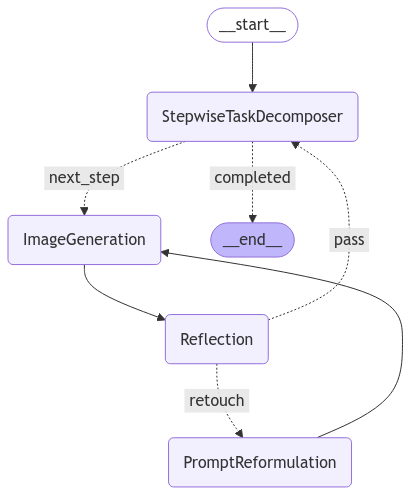

In [14]:
analyzer.show_graph()

---StepwiseTaskDecomposer---
{
    "total_steps": 3,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the base landscape with mountains, forest, and frozen lake",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A vast winter landscape with snow-covered mountain peaks stretching to the horizon. A dense evergreen forest blankets the lower slopes, leading to a colossal frozen lake with a glossy ice surface. The scene is rendered in rich oil painting style with thick brushstrokes and textured impasto technique. Dramatic lighting casts long shadows across the snow, professional landscape composition, inspired by Hudson River School painters.",
                "negative": "summer, warm colors, cartoon style, watercolor, sketch, people, boats, dragon, volcano, abstract, blurry, oversaturated"
            }
        },
        {
            "step_number": 2,
            "de

INFO:retry-bedrock-invocation:trying ImageGeneration() [1/5]


---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{ 'prev_node': 'StepwiseTaskDecomposer',
  'steps': [ { 'control_mode': 'NONE',
               'control_strength': None,
               'description': 'Establish the base landscape with mountains, '
                              'forest, and frozen lake',
               'prompt': { 'negative': 'summer, warm colors, cartoon style, '
                                       'watercolor, sketch, people, boats, '
                                       'dragon, volcano, abstract, blurry, '
                                       'oversaturated',
                           'positive': 'A vast winter landscape with '
                                       'snow-covered mountain peaks stretching '
                                       'to the horizon. A dense evergreen '
                                       'forest blankets the lower slopes, '
                                       'leading to a colossal f

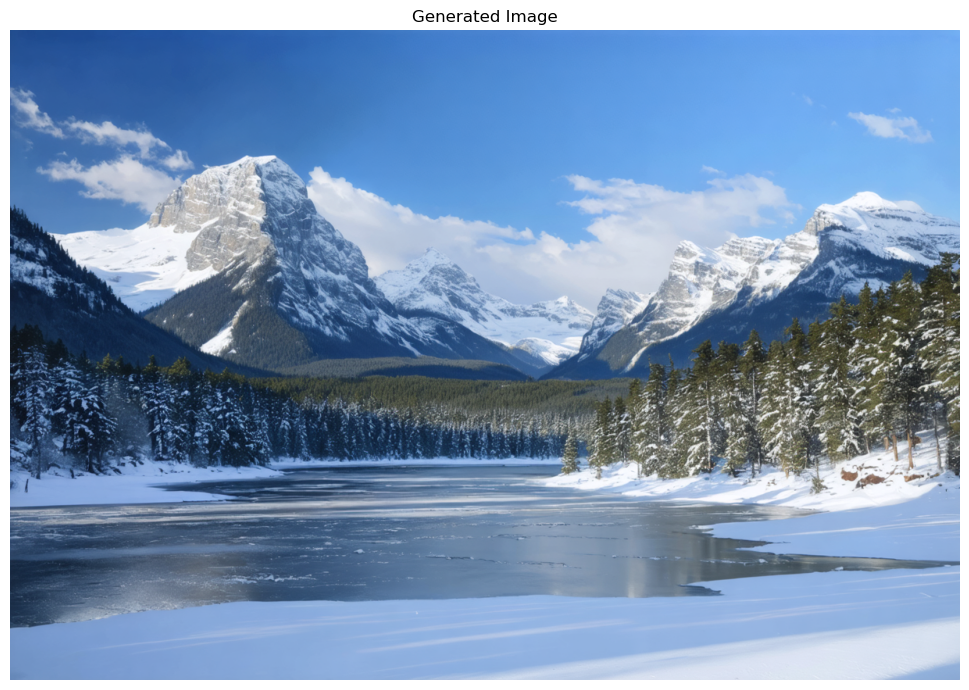

INFO:retry-bedrock-invocation:in retry(), ImageGeneration() returned '{'condition_image': './generated_imgs/GENERATED_IMAGE.png', 'current_step': 1, 'prev_node': 'ImageGeneration'}'


"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 1,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A vast winter landscape with snow-covered mountain peaks stretching to the horizon. A dense evergreen forest blankets the lower slopes, leading to a colossal frozen lake with a glossy ice surface. The scene is rendered in rich oil painting style with thick brushstrokes and textured impasto technique. Dramatic lighting casts long shadows across the snow, professional landscape composition, inspired by Hudson River School painters., negative: summer, warm colors, cartoon style, watercolor, sketch, people, boats, dragon, volcano, abstract, blurry, oversaturated
{
    "retouch": "false",
    "suggestions": [],
    "evaluation": {
        "key_subjects": {
            "mountains": {
                "results": "match",
                "count": "multiple peaks",
                "attribute

INFO:retry-bedrock-invocation:trying ImageGeneration() [1/5]


---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 2,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  2
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'
---ImageGeneration---
current_step 2
condition_image ./generated_imgs/GENERATED_IMAGE.png
prev_node StepwiseTaskDecomposer
seed 6602
_body_generator, control_strength 0.85
Image generator: SD-3-5-Large


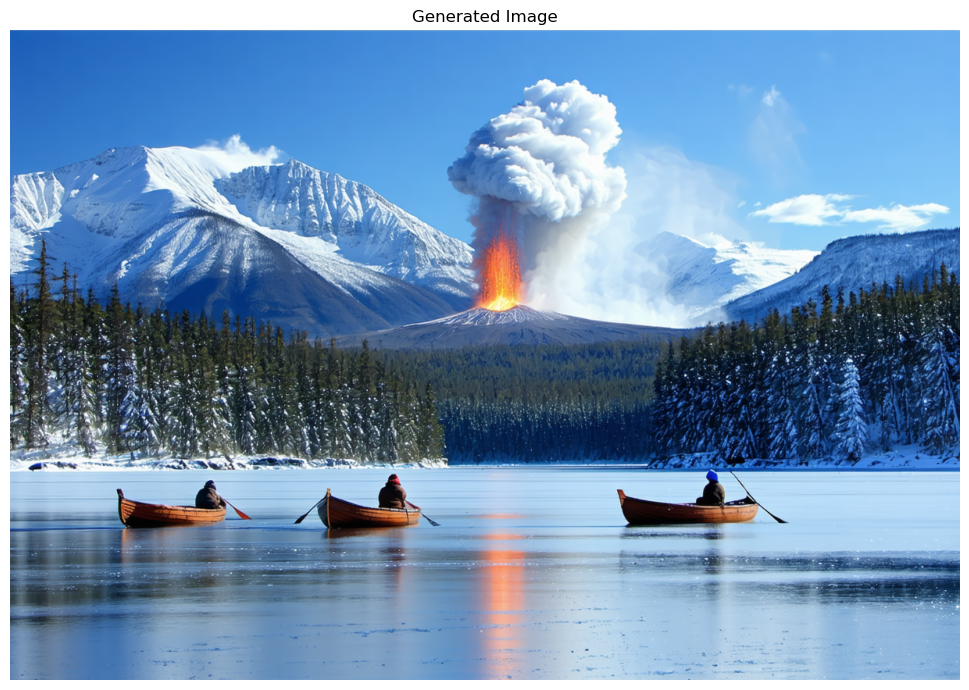

INFO:retry-bedrock-invocation:in retry(), ImageGeneration() returned '{'condition_image': './generated_imgs/GENERATED_IMAGE.png', 'current_step': 2, 'prev_node': 'ImageGeneration'}'


"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 2,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A menacing active volcano looms near the frozen lake, emitting ominous smoke and subtle orange glow. Three wooden boats are scattered across the frozen lake, each carrying one person bundled in winter clothing. Maintain the vast winter landscape with snow-covered mountain peaks, dense evergreen forest, and colossal frozen lake. Oil painting style with thick brushstrokes and textured impasto technique, dramatic lighting, professional landscape composition., negative: summer, warm colors, cartoon style, watercolor, sketch, more than three boats, groups of people, dragon, abstract, blurry, oversaturated
{
    "retouch": "false",
    "suggestions": [],
    "evaluation": {
        "key_subjects": {
            "volcano": {
                "results": "match",
                "count": "1"

INFO:retry-bedrock-invocation:trying ImageGeneration() [1/5]


---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 3,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  3
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'
---ImageGeneration---
current_step 3
condition_image ./generated_imgs/GENERATED_IMAGE.png
prev_node StepwiseTaskDecomposer
seed 62627
_body_generator, control_strength 0.9
Image generator: SD-3-5-Large


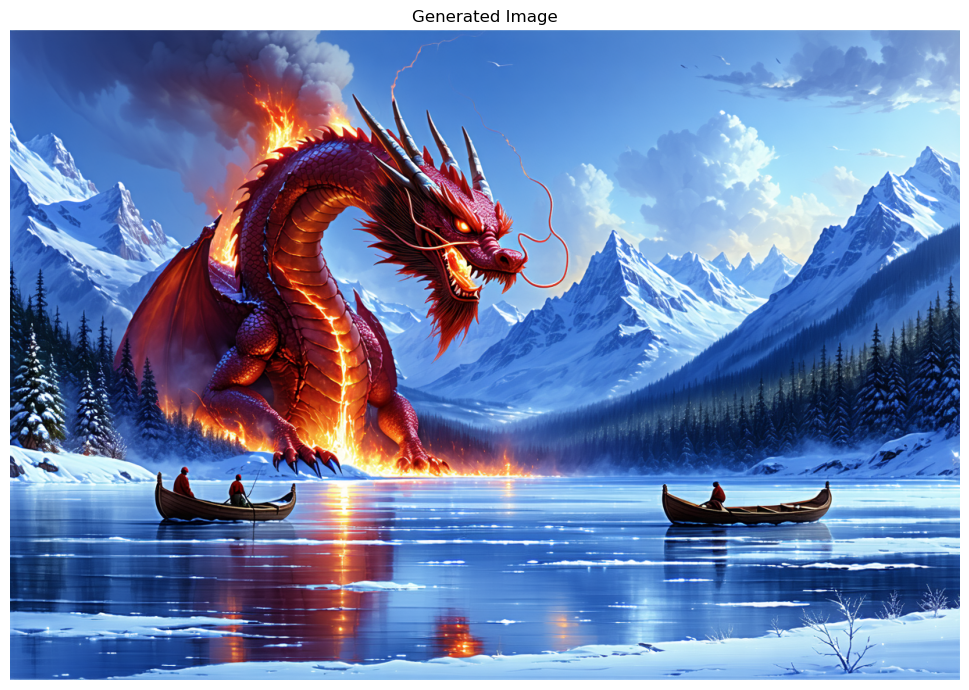

INFO:retry-bedrock-invocation:in retry(), ImageGeneration() returned '{'condition_image': './generated_imgs/GENERATED_IMAGE.png', 'current_step': 3, 'prev_node': 'ImageGeneration'}'


"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 3,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. Maintain the menacing volcano with smoke and glow, three wooden boats each with one person on the frozen lake, vast winter landscape with snow-covered peaks, dense evergreen forest. Oil painting style with thick brushstrokes and textured impasto technique, dramatic lighting emphasizing the dragon's majesty, professional fantasy landscape composition., negative: summer, warm colors, cartoon style, watercolor, sketch, multiple dragons, more than three boats, groups of people, abstract, blurry, oversaturated, cute dragon, small dragon
{
    "retouch": "true",
    "suggestions": [
        "Only two boa

INFO:retry-bedrock-invocation:trying ImageGeneration() [1/5]


=================before
pos: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. Maintain the menacing volcano with smoke and glow, three wooden boats each with one person on the frozen lake, vast winter landscape with snow-covered peaks, dense evergreen forest. Oil painting style with thick brushstrokes and textured impasto technique, dramatic lighting emphasizing the dragon's majesty, professional fantasy landscape composition.
neg: summer, warm colors, cartoon style, watercolor, sketch, multiple dragons, more than three boats, groups of people, abstract, blurry, oversaturated, cute dragon, small dragon
control_strength: 0.9
=================after
pos: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. Three distinct 

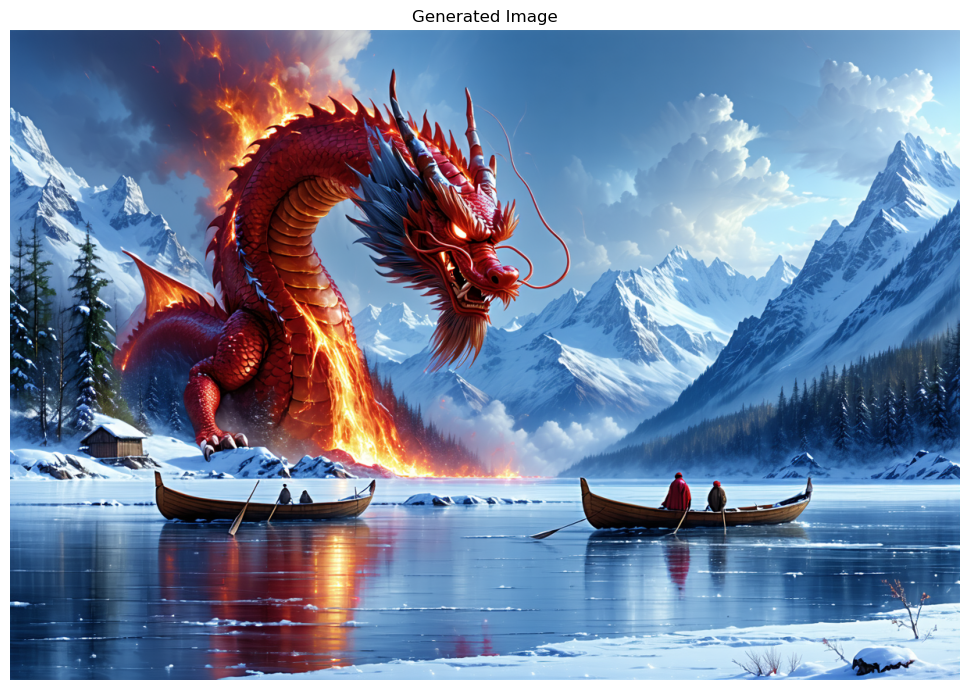

INFO:retry-bedrock-invocation:in retry(), ImageGeneration() returned '{'condition_image': './generated_imgs/GENERATED_IMAGE.png', 'current_step': 3, 'prev_node': 'ImageGeneration'}'


"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 3,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. Three distinct wooden boats, each with a single person, evenly spaced across the frozen lake. Vast winter landscape with snow-covered peaks and dense evergreen forest surrounds the scene. Heavy impasto technique with visible, thick brushstrokes creating rich texture throughout the canvas, especially in the dragon's scales and mountain surfaces, negative: summer, warm colors, cartoon style, watercolor, sketch, multiple dragons, more than three boats, groups of people, abstract, blurry, oversaturated, cute dragon, small dragon, thin paint, smooth canvas, flat texture, two boats
{
    "retouch": "true

INFO:retry-bedrock-invocation:trying ImageGeneration() [1/5]


=================before
pos: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. Three distinct wooden boats, each with a single person, evenly spaced across the frozen lake. Vast winter landscape with snow-covered peaks and dense evergreen forest surrounds the scene. Heavy impasto technique with visible, thick brushstrokes creating rich texture throughout the canvas, especially in the dragon's scales and mountain surfaces
neg: summer, warm colors, cartoon style, watercolor, sketch, multiple dragons, more than three boats, groups of people, abstract, blurry, oversaturated, cute dragon, small dragon, thin paint, smooth canvas, flat texture, two boats
control_strength: 0.85
=================after
pos: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws

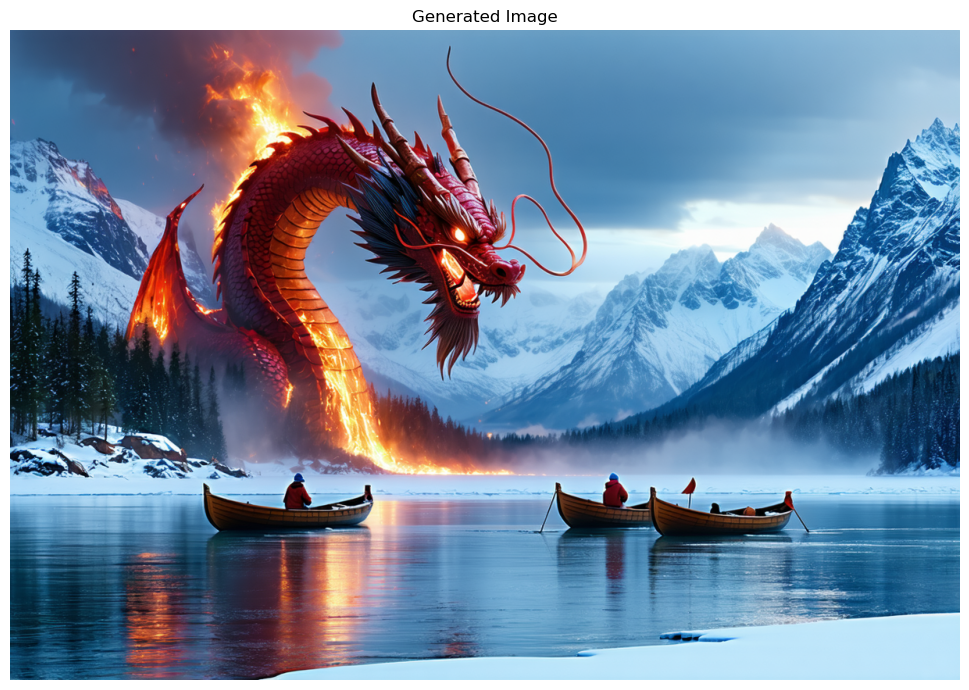

INFO:retry-bedrock-invocation:in retry(), ImageGeneration() returned '{'condition_image': './generated_imgs/GENERATED_IMAGE.png', 'current_step': 3, 'prev_node': 'ImageGeneration'}'


"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 3,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A massive red dragon dominates the sky above the mountains, its scales gleaming with volcanic energy. The dragon's presence commands the heavens as it draws power from the volcano below. EXACTLY THREE wooden boats, EACH WITH ONLY ONE PERSON, evenly spaced across the frozen lake. Vast winter landscape with snow-covered peaks and dense evergreen forest surrounds the scene. EXTREMELY HEAVY impasto technique with PROMINENTLY VISIBLE, EXTREMELY THICK brushstrokes creating deep, rich texture throughout the canvas, emphasizing dragon's scales and mountain surfaces. Paint layers built up in heavy, tactile strokes., negative: summer, warm colors, cartoon style, watercolor, sketch, multiple dragons, more than three boats, two boats, groups of people, multiple people in boats, abstract, blurr

In [16]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        An icy landscape.
        A vast expanse of snow-covered mountain peaks stretches endlessly.
        Beneath them is a dense forest and a colossal frozen lake.
        Three people are boating in three boats in the lake.
        Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar.
        Above the mountain, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow.
        Oil painting
        '''
    ),
    image_model="stable-diffusion"
)

In [15]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        The word 'AWS AIML Specialist' in blue background and white letters is written on a black wall, with a redbike in front of it.
        '''
    ),
    image_model="stable-diffusion"
)

---StepwiseTaskDecomposer---
{
    "total_steps": 2,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the black wall with the text 'AWS AIML Specialist' on a blue background",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A large black wall with text 'AWS AIML Specialist' prominently displayed, white crisp letters on a rectangular blue background panel, professional signage, clean typography, centered composition, high contrast, sharp details, modern design, front view",
                "negative": "blurry text, distorted letters, graffiti, messy, unclear typography, damaged wall, poor lighting"
            }
        },
        {
            "step_number": 2,
            "description": "Add the red bike in front of the wall while maintaining the wall and text",
            "control_mode": "SEGMENTATION",
            "control_strength": 0.85,
            "prompt":


KeyboardInterrupt



In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        One candle in the middle,\
        one sheep and one dogs nearby,\
        three bees in the air,\
        creates a warm atmosphere.
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        A girl is reading a book in the autumn park.
        Plenty of red and yellow leaves are in the park in a cartoon style.
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        The red chair and a wooden table hold the black laptop in thelibrary,\
        with a yellow book on the left floor.
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        One candle in the middle, two sheep and four dogs nearby, three bees in the air, creates a warm atmosphere.
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        The word 'This is from AWS AIML Specialist' in blue background and white letters is written on a road, with a redbike in front of it.
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("A panda holds the bamboo higher than its head and is preparing to eat, in a cartoon style."),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("An oil painting, where a green vintage car, a blue scooter on the left of it and a black bicycle on the right of it, are parked on the road, with two birds in the sky."),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("늦은밤까지 aws 옷을 입고 샘플코드를 작성하고 있는 40대 남성. 책상엔 모니터가 2대가 있고, 주위는 어두우며 모니터 위에 스탠드 등이 켜져 있음. 시선은 모니터를 응시. 실제 사진"),
    image_model="nova-canvas"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        An icy landscape.
        A vast expanse of snow-covered mountain peaks stretches endlessly.
        Beneath them is a dense forest and a colossal frozen lake.
        Three people are boating in three boats in the lake.
        Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar.
        Above the mountain, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow.
        Oil painting
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        Two hot dogs sit on a green plate near a soda cup which are sitting on a white picnic table, while a red bike (on the left of image) and a blue car (on the right of image)are parked nearby.
        A high-resolution DSLR photograph
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        cat in hat
        
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        A happy dog wearing a shirt saying 'I Love Dongjin Jang'. Make sure the text is clear.
        
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        Three boys in green, red, white shirts and blue, black, yellow short pants separately from left to right, are in the rain.
        
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
wo blue hardcover
books on the left
of a rectangular
table, with two red
chairs on the right
and one black couch
on the behind.

In [ ]:
steps = analyzer.invoke(
    ask=dedent('Five cars on the street'),
    image_model="nova-canvas",
    reset=False
)

In [ ]:
steps = analyzer.invoke(
    ask=dedent("An icy landscape. A vast expanse of snow-covered mountain peaks stretches endlessly. Beneath them is a dense forest and a colossal frozen lake. Three people are boating in three boats separately in the lake. Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar. Above, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow. photorealistic, hyperrealistic, high definition, high resolution, highly detailed"),
    image_model="nova-canvas",
    reset=True
)

In [ ]:
import io
import json
import base64
import random
import matplotlib.pyplot as plt

In [ ]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

def _img_generation_and_show(image_generation_model, body, original_image_path, mask_image_path=None):
    # 원본 이미지 로드
    original_image = Image.open(original_image_path)
    
    # 생성된 이미지 얻기
    response = image_generation_model.bedrock_client.invoke_model(
        body=body,
        modelId=image_generation_model.model_id
    )
    response_body = json.loads(response.get("body").read())
    base64_image = response_body.get("images")[0]
    image_data = base64.b64decode(base64_image)
    generated_image = Image.open(io.BytesIO(image_data))
    
    # mask_image_path의 유무에 따라 subplot 개수 조정
    if mask_image_path:
        # 마스크 이미지가 있는 경우 3개의 subplot 생성
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 마스크 이미지 표시
        mask_image = Image.open(mask_image_path)
        ax2.imshow(mask_image)
        ax2.axis('off')
        ax2.set_title('Mask Image')
        
        # 생성된 이미지 표시
        ax3.imshow(generated_image)
        ax3.axis('off')
        ax3.set_title('Generated Image')
    else:
        # 마스크 이미지가 없는 경우 2개의 subplot 생성
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 생성된 이미지 표시
        ax2.imshow(generated_image)
        ax2.axis('off')
        ax2.set_title('Generated Image')

    # save images
    img_path = './generated_imgs/GENERATED_IMAGE_TEST.png'
    generated_image.save(img_path, "PNG")
    
    plt.tight_layout()  # 레이아웃 조정
    plt.show()


In [ ]:
steps["steps"][0]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][0]["prompt"]["positive"],
            "negativeText": steps["steps"][0]["prompt"]["negative"],
            #"conditionImage": origin_img_base64,
            #"controlMode": "SEGMENTATION", # "CANNY_EDGE" | "SEGMENTATION", 
            #"controlStrength": 0.5 # 0 to 1.0
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][1]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][1]["prompt"]["positive"],
            "negativeText": steps["steps"][1]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][1]["control_mode"].upper(),
            "controlStrength": steps["steps"][1]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][2]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][2]["prompt"]["positive"],
            "negativeText": steps["steps"][2]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][2]["control_mode"].upper(),
            "controlStrength": steps["steps"][2]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][3]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][3]["prompt"]["positive"],
            "negativeText": steps["steps"][3]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][3]["control_mode"].upper(),
            "controlStrength": steps["steps"][3]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST-2.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': 'A restroom features black and white checkered flooring, two toilets of which has a black seat and lid and the other a white seat and lid, two black sinks.',
            #"negativeText": steps["steps"][3]["prompt"]["negative"],
            #"conditionImage": origin_img_base64,
            #"controlMode": steps["steps"][3]["control_mode"].upper(),
            #"controlStrength": steps["steps"][3]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 230, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:

analyzer.invoke(
    ask=dedent("용을 산 꼭대기에 위치하도록 해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("용이 화산이 발생하는 산 꼭대기에서 마치 화산에서 튀어 나오는 것 처럼 해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("전체 몸이 다 보이도록 변경해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("high-end camera, shot on Canon EOS R5, 스튜디오 촬영, photorealistic, 한 남성 모델이 세탁기 옆에서 세탁기 광고를 촬영하는 모습"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 예쁜 동양인 여성 미술 원장, realistic editorial photo"),
    image_model="nova-canvas"
)

In [ ]:
bb

In [ ]:
analyzer.invoke(
    ask=dedent("사람이 창문을 보고 서 있는 모습으로 변경해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("여성이 서있지 않고 앉아있는 자세로 촬영되어 있어 'standing'과 차이 가 있습니다. 이 부분을 수정해서 생성해 주세요"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다"),
    image_model="nova-canvas"
)

In [ ]:
 def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

def _png_to_bytes( file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
#img_path = state["img_path"] # PNG 파일 경로
img_path = "./generated_imgs/GENERATED_IMAGE.png"
messages = []  
llm_caller = llm_call(
    llm=llm,
    verbose=False
)
ask_reformulation = "어두운 하늘의 구름을 그려줘"

system_prompts = dedent(
    '''
    <task>
    이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
    </task>

    <instruction>
    1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
       - 요청된 주요 객체나 대상
       - 구체적인 시각적 특성 (색상, 크기, 형태 등)
       - 구도나 배치에 대한 요구사항
       - 스타일이나 분위기에 대한 설명
       - 특수한 효과나 기법에 대한 요청

    2. 생성된 이미지를 다음 측면에서 평가하세요:
       - 요청된 주요 객체의 존재 여부와 정확성
       - 시각적 특성의 구현 정도
       - 구도와 배치의 일치도
       - 전반적인 스타일과 분위기의 부합성
       - 특수 효과나 기법의 적용 상태

    3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
       - 객체 정확도 (0-20점)
       - 시각적 특성 구현도 (0-20점)
       - 구도/배치 일치도 (0-20점)
       - 스타일/분위기 부합도 (0-20점)
       - 전반적 완성도 (0-20점)
    4. DO NOT use ```json``` in response.
    </instruction>

    <scoring_criteria>
    - 객체 정확도 (20점)
      * 20점: 모든 요청 객체가 정확히 표현됨
      * 15점: 주요 객체는 있으나 일부 세부사항 누락
      * 10점: 일부 주요 객체 누락 또는 부정확
      * 5점: 대부분의 객체가 부정확하거나 누락
      * 0점: 요청 객체와 전혀 다른 내용

    - 시각적 특성 구현도 (20점)
      * 20점: 모든 시각적 특성이 정확히 구현됨
      * 15점: 대부분의 특성이 구현되었으나 일부 미흡
      * 10점: 주요 특성만 부분적으로 구현
      * 5점: 대부분의 특성이 미구현
      * 0점: 요청된 특성과 전혀 다름

    - 구도/배치 일치도 (20점)
      * 20점: 요청된 구도와 완벽히 일치
      * 15점: 전반적 구도는 유사하나 일부 차이
      * 10점: 기본적인 구도만 일치
      * 5점: 구도가 크게 다름
      * 0점: 전혀 다른 구도

    - 스타일/분위기 부합도 (20점)
      * 20점: 의도된 스타일과 분위기를 완벽히 구현
      * 15점: 유사한 스타일과 분위기 표현
      * 10점: 부분적으로만 의도된 분위기 표현
      * 5점: 의도와 다른 분위기
      * 0점: 전혀 다른 스타일과 분위기

    - 전반적 완성도 (20점)
      * 20점: 전문적 수준의 완성도
      * 15점: 양호한 완성도
      * 10점: 기본적인 완성도
      * 5점: 미흡한 완성도
      * 0점: 매우 낮은 완성도
    </scoring_criteria>

    <output_format>
     JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
    {{
       "score": "일치도 스코어",
       "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
    }}
    </output_format>

    <considerations>
    - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
    - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
    - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
    - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
    - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
    </considerations>

    <restrictions>
    - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
    - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
    - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
    - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
    </restrictions>

    이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
    각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
    '''
 )

system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

user_prompts = dedent(
    '''
    Here is the question: <ask>{ask}</ask>
    '''
)

context = {
    "ask": ask_reformulation
}
user_prompts = user_prompts.format(**context)

img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

resp, messages_updated = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

In [ ]:
#기존 파일

In [ ]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))

            fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_title('Generated Image')

            plt.tight_layout()  # 레이아웃 조정
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, pos_prompt, neg_prompt="", condition_image=None, control_strength=None, seed=1):
        
        
        
        print ("_body_generator, control_strength", control_strength)
    
        if condition_image == None:
            self.image_generation_model.model_id = "stability.stable-image-ultra-v1:1"
            print (f'Image generator: SD-Ultra')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "text-to-image",
                "aspect_ratio": "1:1",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
                "output_format": "png",
                "seed": seed
            }
        else:
            self.image_generation_model.model_id = "stability.sd3-5-large-v1:0"
            print (f'Image generator: SD-3-5-Large')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "image-to-image",
                "strength": control_strength, # nova랑 반대
                "image": condition_image,
                "output_format": "png",
                "seed": seed
            }

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def StepwiseTaskDecomposer(state):

            self.timer.start()
            self.timer.reset()
            
            print("---StepwiseTaskDecomposer---")
            ask = state["ask"]
            current_step = state.get("current_step", 1)
            messages = []
        
            system_prompts = dedent(
                
                '''
                You are an agent that plans steps for stepwise image generation based on user requests.

                Core Responsibilities:
                1. Break down user requests into manageable steps that:
                   - Maintain consistency with previous steps
                   - Follow control mode restrictions (NONE for step 1, SEGMENTATION after)
                   - Progress from core elements to details
                   - Use appropriate control strength for smooth transitions

                2. For each step, provide:
                   - Start with new elements in prompt generation
                   - Step description
                   - Image generation prompt that have to maintain key subjects(people, car, etc) and elements  from previous steps while clearly specifying new additions
                   - Control mode (NONE/SEGMENTATION)
                   - Control strength (0.0-1.0, N/A for step 1)

                Step Planning Guidelines:
                First Step (Composition & Subject):
                - Uses NONE control mode
                - No control strength applicable
                - Must establish:
                  * Overall scene composition
                  * Main subjects and objects
                  * Spatial relationships and viewpoint
                  * Foreground/background structure
                  * Space allocation for future elements

                Subsequent Steps:
                - Uses SEGMENTATION control mode
                - Each prompt should explicitly reference maintaining previous subjects and elements
                - Control strength: 0.8-0.95 recommended
                - Consider new elements' impact when selecting control strength
                
                Scene Composition Rules:
                1. Foreground/Background
                   - Specify clear spatial relationships
                   - Maintain distinct layering
                   - Use explicit positioning terms

                2. Spatial Relationships
                   - Use clear position indicators (left, right, near, far)
                   - Consider depth and perspective
                   - Be explicit about distances and relationships

                Prompt Writing Guidelines:
                - Use image captioning style
                - Start with new elements
                - Maintain consistent style across steps
                - Use clear, simple language
                - Keep under 10,000 characters
                - Include:
                  * Spatial relationships
                  * Depth indicators
                  * Viewing angles when relevant
                  * Style keywords at end

                Output Format:
                DO NOT include any text outside the JSON format in the response
                You must provide your response in the following JSON format:
                {
                    "total_steps": <number_of_steps>,
                    "steps": [
                        {
                            "step_number": <number>,
                            "description": <string>,
                            "control_mode": <"NONE"/"SEGMENTATION">,
                            "control_strength": <null/float>,
                            "prompt": {
                                "positive": <string>,
                                "negative": <string>
                            }
                        }
                    ]
                }
                ```

                Key Requirements:
                - Maximum 1-4 steps
                - First step unconditional
                - Each step builds on previous
                - Maintain style consistency across steps through:
                  * Matching artistic style keywords
                  * Consistent quality enhancers
                  * Uniform lighting/atmosphere descriptions
                  * Consistent camera/perspective terms
                
                '''
            )

            if current_step == 1:
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                user_prompts = dedent(
                    '''
                    Here is user's ask: <ask>{ask}</ask>
                    '''
                )
                context = {
                    "ask": ask,
                }
                user_prompts = user_prompts.format(**context)
                           
                message = self._get_message_from_string(role="user", string=user_prompts)
                self.messages.append(message)
                messages.append(message)
                
                resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                self.messages.append(ai_message)
                            
                results = json.loads(resp['text'])
                total_steps, steps = results["total_steps"], results["steps"]
                should_next_step = "next_step"
            
                return self.state(
                    total_steps=total_steps,
                    steps=steps,
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            else:
                generation_steps = state["steps"]
                if current_step <= len(generation_steps):
                    print ("---GO TO IMAGE GENERATION---")
                    print ("current_step: ", current_step)
                    should_next_step = "next_step"
                else:
                    should_next_step = "completed"
                    
                return self.state(
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            
            
        def ShouldStepwiseImageGeneration(state):

            print("---ShouldStepwiseImageGeneration---")
            return state["should_next_step"]
        
        @retry(total_try_cnt=5, sleep_in_sec=60, retryable_exceptions=(ClientError,))
        def ImageGeneration(state):
            
            print("---ImageGeneration---")
            generation_steps, current_step = state["steps"], state.get("current_step", 1)
            condition_image = state.get("condition_image", None)
            seed = state.get("seed", 1)
            prev_node = state.get("prev_node", None)
            
            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            control_mode = generation_steps[current_step-1]["control_mode"].upper()
            control_strength = generation_steps[current_step-1]["control_strength"]
            if prev_node == "PromptReformulation": seed = random.randint(0, 100000)

            seed = random.randint(0, 100000)
            print ("current_step", current_step)
            print ("condition_image", condition_image)
            print ("prev_node", prev_node)
            print ("seed", seed)
                      
            if condition_image is not None: #and current_step != 1:
                img_bytes, img_base64 = self._png_to_bytes(condition_image)
                condition_image = img_base64
            else:
                condition_image = None
            
            body = self._body_generator(
                pos_prompt=pos_prompt,
                neg_prompt=neg_prompt,
                condition_image=condition_image,
                control_strength=control_strength, # nova랑 반대
                seed=seed
            )
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            condition_image = self.show_save_image(base64_image)
            
            return self.state(
                condition_image=condition_image,
                current_step=current_step,
                prev_node="ImageGeneration"
            )
        
        def PromptReformulation(state):
            
            print("---PromptReformulation---")
            generation_steps = state["steps"]
            suggestions = state["suggestions"]
            current_step = state["current_step"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            original_prompt = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages=[]
            
            system_prompts = dedent(
                '''
                You are an agent that enhances image generation prompts based on provided suggestions. Your role is to:

                1. Process Input:
                   - Original image generation prompt
                   - Provided suggestions for improvement

                2. Enhance Prompt:
                   - Maintain the core elements and structure
                   - Keep the total prompt length under 10,000 characters
                   - Write prompts as concisely as possible
                   - 제거되어야 하는 사항이 있다면 "negative" prompt에 넣어 주세요. 
                   
                3. Determine Control Strength:
                   - 0.8-0.95: Optimal range for balanced transformation
                   - A value of 0 would yield an image that is identical to the input. A value of 1 would be as if you passed in no image at all. Range: [0, 1]
                   - Consider the impact on existing elements

                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "prompt_repo": {
                        "positive": <improved prompt incorporating suggestions>,
                        "negative": <negative prompt>,
                        "control_strength": <float between 0.0 and 1.0>
                    }
                }

                Style Consistency Guidelines:
                - DO NOT include style-related keywords:
                  * Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                  * Remove resolution indicators (HD, 8K, etc.)
                  * Remove lighting descriptors (dramatic, cinematic, etc.)
                  * Focus only on describing desired changes and additions
            
                General Guidelines:
                - Keep the original prompt's main structure
                - Integrate suggestions naturally
                - Use image captioning style
                - Maintain clear spatial relationships
                - Ensure coherent flow in descriptions
                - Preserve essential elements from original prompt
                - Use concise, clear descriptions
                - Prioritize critical elements when length is constrained
                - Remove redundant or unnecessary descriptors
                - Stay within 10,000 character limit
                - Ensure style consistency with previous steps
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is original prompt: <original_prompt>{original_prompt}</original_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "original_prompt": original_prompt,
                "suggestions": suggestions
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
                        
            results = json.loads(resp['text'])
            prompt_repo = results["prompt_repo"]

            print ("=================before")

            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            generation_steps[current_step-1]["prompt"]["positive"] = prompt_repo["positive"]
            generation_steps[current_step-1]["prompt"]["negative"] = prompt_repo["negative"]
            generation_steps[current_step-1]["control_strength"] = prompt_repo["control_strength"]
            
            print ("=================after")
            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            return self.state(
                generation_steps=generation_steps,
                prev_node="PromptReformulation"
            )
        
        def Reflection(state):
            
            print("---Reflection---")
            generation_steps = state["steps"]
            current_step = state["current_step"]
            condition_image = state["condition_image"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            step_ask = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages = []
            
            print ("step_ask", step_ask)
        
            system_prompts = dedent(
                '''
               You are an expert in evaluating the alignment between image generation requests and generated images.

                Step 1: Critical Elements Validation
                1. Extract and Validate Numerical Requirements:
                   - Count of main subjects (MUST match exactly)
                   - Required measurements or proportions
                   - Specific positioning requirements
                   Any mismatch in these → automatic retouch=true

                2. Create Validation Rules:
                   Rule 1: Count Validation
                   ```javascript
                   if (requested_count !== actual_count) {
                       retouch = true;
                       suggestions.push(`요청된 ${subject}의 개수(${requested_count})와 실제 이미지의 개수(${actual_count})가 일치하지 않습니다.`);
                   }
                   ```

                Step 2: Detailed Evaluation
                1. Element Presence Check:
                   - Critical elements (retouch=true if missing)
                   - Secondary elements (note in evaluation)
                   - Required attributes

                2. Quality Assessment:
                   - Style compliance
                   - Composition
                   - Technical execution

                Step 3: Result Generation
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "retouch": "true/false", // MUST be true if any critical mismatch
                    "suggestions": [
                        "Critical mismatches first",
                        "Secondary issues second"
                    ],
                    "evaluation": {
                        "key_subjects": {
                            "subject_name": {
                                "count": "REQUIRED - Must match exactly",
                                "attributes": "Additional details"
                            }
                        },
                        "composition": {...},
                        "style": {...}
                    }
                }

                Critical Rules:
                1. ANY numerical mismatch in key subjects → retouch="true"
                2. ANY missing required element → retouch="true"
                3. ALL positional requirements must be met
                4. Evaluation must clearly indicate mismatches
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the user requests: <user_requests>{ask}</user_requests>
                '''
            )    
            context = {
                "ask": step_ask
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(condition_image)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = json.loads(resp['text'])
            suggestions = results["suggestions"]
            retouch, suggestions = results["retouch"], results["suggestions"]
            if retouch == "true":
                retry_count += 1
                if retry_count <= 2: should_regeneration = "retouch"
                else:
                    retry_count = 0
                    current_step += 1
                    should_regeneration = "pass"
            else:
                retry_count = 0  
                current_step += 1
                should_regeneration = "pass"

            return self.state(
                retouch=retouch,
                suggestions=suggestions,
                retry_count=retry_count,
                current_step=current_step,
                should_regeneration=should_regeneration,
                prev_node="Reflection"
            )
            messages = []

        def ShouldImageRegeneration(state):
            
            print("---ShouldImageRegeneration---")

            return state["should_regeneration"]

        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("StepwiseTaskDecomposer", StepwiseTaskDecomposer)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("ImageGeneration", ImageGeneration)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("Reflection", Reflection)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        workflow.add_node("PromptReformulation", PromptReformulation)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        workflow.add_conditional_edges(
            "StepwiseTaskDecomposer",
            # 에이전트 결정 평가
            ShouldStepwiseImageGeneration,
            {
                # 도구 노드 호출
                "next_step": "ImageGeneration",
                "completed": END,
            },
        )
        workflow.add_edge("ImageGeneration", "Reflection")
        workflow.add_conditional_edges(
            "Reflection",
            # 에이전트 결정 평가
            ShouldImageRegeneration,
            {
                # 도구 노드 호출
                "pass": "StepwiseTaskDecomposer",
                "retouch": "PromptReformulation"
            },
        )
        workflow.add_edge("PromptReformulation", "ImageGeneration")
        
        #workflow.add_edge("prompt_generation_for_image", "image_generation")
        #workflow.add_edge("image_generation", "reflection")
        # workflow.add_conditional_edges(
        #     "reflection",
        #     # 에이전트 결정 평가
        #     should_image_regeneration,
        #     {
        #         # 도구 노드 호출
        #         "continue": END,
        #         "regeneration": "ask_reformulation",
        #     },
        # )

        # 시작점을 설정합니다.
        workflow.set_entry_point("StepwiseTaskDecomposer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
            
        inputs = self.state(
            ask=kwargs["ask"],
            image_model=kwargs["image_model"]
        )

        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)

                #if key == "StepwiseTaskDecomposer": steps = value
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")

        #return steps
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            